In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
import random
from collections import deque
import numpy as np

In [2]:
def convert_edges_to_csv(edge_file):
    cleaned_data = []
    with open(edge_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith("#") or line.startswith("%") or line == "":
                continue
            parts = line.split()
            try:
                if len(parts) >= 3:
                    u, v, w = int(parts[0]), int(parts[1]), float(parts[2])
                elif len(parts) == 2:
                    u, v = int(parts[0]), int(parts[1])
                    w = 1.0
                else:
                    continue
                cleaned_data.append([u, v, w])
            except ValueError:
                continue

    df = pd.DataFrame(cleaned_data, columns=['source', 'target', 'weight'])
    csv_file = edge_file.replace('.edges', '.csv')
    df.to_csv(csv_file, index=False)
    print(f"✅ Saved cleaned CSV: {csv_file}")


In [3]:
def convert_amazon_format_to_csv(edge_file):
    cleaned_data = []
    user_map = {}
    item_map = {}
    user_counter = 0
    item_counter = 1_000_000  # Offset to keep users/items distinct

    with open(edge_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith("#") or line.startswith("%") or line == "":
                continue
            parts = line.split(",")
            if len(parts) < 3:
                continue
            user_id, item_id, rating = parts[0], parts[1], parts[2]

            try:
                rating = float(rating)
            except ValueError:
                continue

            # Map user to int
            if user_id not in user_map:
                user_map[user_id] = user_counter
                user_counter += 1
            u = user_map[user_id]

            # Map item to int
            if item_id not in item_map:
                item_map[item_id] = item_counter
                item_counter += 1
            v = item_map[item_id]

            cleaned_data.append([u, v, rating])

    df = pd.DataFrame(cleaned_data, columns=['source', 'target', 'weight'])
    csv_file = edge_file.replace('.edges', '.csv')
    df.to_csv(csv_file, index=False)
    print(f"✅ Saved cleaned CSV: {csv_file}")


In [4]:
edge_files = [
    "rec-amz-books.edges",
    "rec-amz-Video-Games.edges",
    "rec-movielens.edges",
    "rec-movielens-tag-movies-10m.edges",
    "rec-movielens-user-movies-10m.edges"
]



In [5]:

for edge_file in edge_files:
    if "Video-Games" in edge_file or "books" in edge_file:
        convert_amazon_format_to_csv(edge_file)
    else:
        convert_edges_to_csv(edge_file)


KeyboardInterrupt: 

In [6]:
def load_edge_list(file_path):
    df = pd.read_csv(file_path)
    G = nx.from_pandas_edgelist(df, 'source', 'target', edge_attr='weight')
    return G


In [7]:
def bfs_sample(G, target_nodes):
    visited = set()
    queue = deque()
    start_node = random.choice(list(G.nodes()))
    queue.append(start_node)
    visited.add(start_node)

    while len(visited) < target_nodes and queue:
        current = queue.popleft()
        for neighbor in G.neighbors(current):
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append(neighbor)
            if len(visited) >= target_nodes:
                break

    sampled_nodes = list(visited)
    return G.subgraph(sampled_nodes).copy()


In [8]:
def sample_connected_subgraph(G, target_nodes):
    if G.number_of_nodes() == 0:
        print("⚠️ Graph is empty. Skipping sampling.")
        return G

    if nx.is_connected(G):
        if G.number_of_nodes() <= target_nodes:
            return G
        else:
            return bfs_sample(G, target_nodes)

    # Graph is disconnected
    largest_cc = max(nx.connected_components(G), key=len)
    G_lcc = G.subgraph(largest_cc).copy()

    if G_lcc.number_of_nodes() < target_nodes:
        print(f"⚠️ Largest component only has {G_lcc.number_of_nodes()} nodes — using all of it.")
        return G_lcc

    return bfs_sample(G_lcc, target_nodes)


In [9]:
class DisjointSetUnion:
    def __init__(self, n):
        self.parent = list(range(n))
        self.rank = [0]*n

    def find(self, x):
        while self.parent[x] != x:
            self.parent[x] = self.parent[self.parent[x]]
            x = self.parent[x]
        return x

    def union(self, x, y):
        rx, ry = self.find(x), self.find(y)
        if rx == ry:
            return False
        if self.rank[rx] < self.rank[ry]:
            self.parent[rx] = ry
        elif self.rank[ry] < self.rank[rx]:
            self.parent[ry] = rx
        else:
            self.parent[ry] = rx
            self.rank[rx] += 1
        return True

def kruskal_mst_with_steps(G):
    edges = list(G.edges(data='weight'))
    edges.sort(key=lambda x: x[2])  # sort by weight

    dsu = DisjointSetUnion(G.number_of_nodes())
    node_to_idx = {node: idx for idx, node in enumerate(G.nodes())}

    mst_edges = []
    steps = []

    for u, v, w in edges:
        if dsu.union(node_to_idx[u], node_to_idx[v]):
            mst_edges.append((u, v, w))
            steps.append(mst_edges.copy())  # record incremental steps

    return mst_edges, steps


In [11]:
results = []

sample_size = {
    "rec-amz-books.csv": 40000,
    "rec-amz-Video-Games.csv": 10000,
    "rec-movielens.csv": 50000,
    "rec-movielens-tag-movies-10m.csv": 20000,
    "rec-movielens-user-movies-10m.csv": 30000,
}

dataset_files = [f.replace(".edges", ".csv") for f in edge_files]

for dataset in dataset_files:
    print(f"\n📂 Processing: {dataset}")
    G = load_edge_list(dataset)

    sample_target = sample_size.get(os.path.basename(dataset))

    if sample_target is not None:
        print(f"📉 Sampling {sample_target} connected nodes...")
        G = sample_connected_subgraph(G, sample_target)
        print(f"✅ Sampled nodes: {G.number_of_nodes()}, edges: {G.number_of_edges()}")

    start_time = time.time()
    mst_edges, steps = kruskal_mst_with_steps(G)
    end_time = time.time()

    total_cost = sum(w for _, _, w in mst_edges)
    exec_time = end_time - start_time


    print(f"✅ MST total cost: {total_cost:.2f}")
    print(f"⏱️ Execution time: {exec_time:.2f} seconds")

    results.append({
        "Dataset": os.path.basename(dataset),
        "Nodes": G.number_of_nodes(),
        "Edges": G.number_of_edges(),
        "MST Cost": total_cost,
        "Execution Time (s)": exec_time
    })



📂 Processing: rec-amz-books.csv
📉 Sampling 40000 connected nodes...
✅ Sampled nodes: 40000, edges: 88229
✅ MST total cost: 156743.00
⏱️ Execution time: 12.32 seconds

📂 Processing: rec-amz-Video-Games.csv
📉 Sampling 10000 connected nodes...
✅ Sampled nodes: 10000, edges: 27338
✅ MST total cost: 36604.00
⏱️ Execution time: 4.38 seconds

📂 Processing: rec-movielens.csv
📉 Sampling 50000 connected nodes...
✅ Sampled nodes: 50000, edges: 7645561
✅ MST total cost: 58296.50
⏱️ Execution time: 59.52 seconds

📂 Processing: rec-movielens-tag-movies-10m.csv
📉 Sampling 20000 connected nodes...
✅ Sampled nodes: 16528, edges: 71081
✅ MST total cost: 16527.00
⏱️ Execution time: 20.00 seconds

📂 Processing: rec-movielens-user-movies-10m.csv
📉 Sampling 30000 connected nodes...
✅ Sampled nodes: 7601, edges: 55395
✅ MST total cost: 7600.00
⏱️ Execution time: 11.42 seconds


In [12]:
df_results = pd.DataFrame(results)
df_results_sorted = df_results.sort_values(by='Nodes', ascending=True)
df_results_sorted.reset_index(drop=True, inplace=True)
df_results_sorted


,Dataset,Nodes,Edges,MST Cost,Execution Time (s)
0,rec-movielens-user-movies-10m.csv,7601,55395,7600.0,11.423549
1,rec-amz-Video-Games.csv,10000,27338,36604.0,4.377066
2,rec-movielens-tag-movies-10m.csv,16528,71081,16527.0,19.995813
3,rec-amz-books.csv,40000,88229,156743.0,12.321593
4,rec-movielens.csv,50000,7645561,58296.5,59.518454


In [13]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def animate_mst_steps(G, steps, save_path="boruvka_animation.gif", max_frames=50):
    pos = nx.spring_layout(G, seed=42)  # Fixed layout
    fig, ax = plt.subplots(figsize=(6, 4))  # Smaller size

    def update(i):
        ax.clear()
        ax.set_title(f"Step {i+1}")
        ax.axis('off')
        step_edges = steps[min(i, len(steps)-1)]
        nx.draw_networkx_nodes(G, pos, node_size=10, ax=ax)
        nx.draw_networkx_edges(G, pos, edgelist=step_edges, edge_color='red', width=1, ax=ax)

    frames = min(len(steps), max_frames)
    ani = animation.FuncAnimation(fig, update, frames=frames, interval=500, repeat=False)

    ani.save(save_path, writer='pillow', fps=2)
    print(f"🎥 GIF saved to: {save_path}")


📊 Kruskal MST Cost: 1199.00


C:\Users\iasma\AppData\Local\Temp\ipykernel_23696\573063357.py:14: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=step_edges, edge_color='red', width=1, ax=ax)


🎥 GIF saved to: kruskal_animation.gif


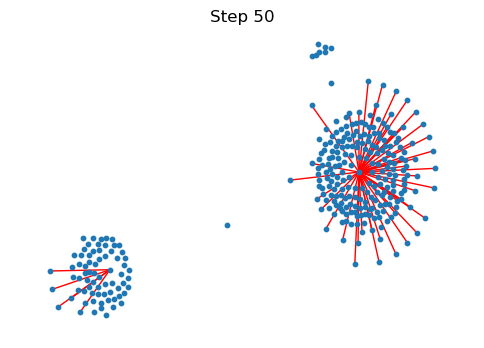

In [14]:
dataset = "rec-amz-books.csv"
G = load_edge_list(dataset)
G = sample_connected_subgraph(G, 300)

mst_edges, steps = kruskal_mst_with_steps(G)
total_cost = sum(w for _, _, w in mst_edges)
print(f"📊 Kruskal MST Cost: {total_cost:.2f}")

animate_mst_steps(G, steps, save_path="kruskal_animation.gif")
